In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
from collections import deque

from controllers.game_controller import GameController
from drl.agent import DRLAgent
from models.players.random_player import RandomPlayer
from models.players.drl_player import DRLPlayer
from utils import get_reward_from_winner

In [3]:
def run_validation(drl_players, n_episodes_validation):
    game_controller = GameController()
    game_controller.view.update_view(print_function=lambda *args, **kwargs: 0)
    players = [
        drl_players[0],
        RandomPlayer(1, game_controller.game)
    ]
    game_controller.players = players
    
    # Disable train mode
    players[0].train_mode = False

    validation_scores = []
    for i in range(1, n_episodes_validation+1):
        episode_winner = game_controller.run_episode(eval_mode=True)
        validation_score = get_reward_from_winner(0, episode_winner)
        validation_scores.append(validation_score)
    
    # Re-enable train mode
    players[0].train_mode = True
    
    return np.mean(validation_scores)

In [4]:
def init_train(game_controller, drl_players, model_path=None, 
                                eps_start=1.0, eps_end=0.01, eps_decay=0.9999):
        n_episodes = 100
        checkpoint_each = 500
        validate_each = 5
        n_episodes_validation = 10
        train_args = {
            'eps': eps_start,
            'eps_end': eps_end,
            'eps_decay': eps_decay
        }
        
        game_controller.view.update_view(print_function=lambda *args, **kwargs: 0)
        game_controller._load_train(drl_players)
        for player in range(2):
            drl_players[player].update_epsilon(eps_start)

        winners = []
        try:
            validation_scores = []
            validation_scores_window = deque(maxlen=100)
            start = time.time()
            for i in range(1, n_episodes+1):
                episode_winner = game_controller.run_episode(train_mode=True, train_args=train_args)
                winners.append(episode_winner)
                game_controller.game.reset()

                if i%validate_each == 0:
                    mean_validation_score = run_validation(drl_players, n_episodes_validation)

                    validation_scores.append(mean_validation_score)
                    validation_scores_window.append(mean_validation_score)
                    mean_validation_score_last_runs = np.mean(validation_scores_window)

                    print("\rEpisode #{:4d}  |  "
                        "Val. Score: {:+5.2f}  |  "
                        "Avg. Val. Score: {:+5.2f}  |  "
                        "Epsilon: {:5.3f}  |  "
                        "Time elapsed: {:.2f}s".format(i, mean_validation_score,
                                            mean_validation_score_last_runs, train_args['eps'], time.time() - start)
                    )

                if i%checkpoint_each == 0:
                    drl_players[0].agent.save_model()
                    print('Checkpoint saved!')
        except KeyboardInterrupt:
            pass

        # save model after all episodes
        drl_players[0].agent.save_model(model_path)
        print('Model saved!')

        return validation_scores

In [5]:
def plot_metrics(metrics):
    fig, ax = plt.subplots(figsize=(18,6))
    ax.plot(metrics)
    pd.Series(metrics).rolling(100, 1).mean().plot(ax=ax, label='MA(100)')
    plt.show()

In [6]:
controller = GameController()
drl_agent = DRLAgent(
    state_size=controller.game.N*controller.game.N+2,
    bid_action_size=1,
    board_action_size=controller.game.N*controller.game.N,
    seed=None,
    checkpoint_path='../checkpoints/checkpoint.pt'
)

In [7]:
eps_start = 1.0
eps_end = 0.01
eps_decay = 0.9999
drl_players = [DRLPlayer(i, controller.game, drl_agent, train_mode=True) for i in range(2)]
validation_scores = init_train(controller, drl_players, model_path='../checkpoints/model.pt',
                   eps_start=eps_start, eps_end=eps_end, eps_decay=eps_decay)

Episode #   5  |  Val. Score: +1.00  |  Avg. Val. Score: +1.00  |  Epsilon: 0.996  |  Time elapsed: 0.14s
Episode #  10  |  Val. Score: +1.00  |  Avg. Val. Score: +1.00  |  Epsilon: 0.993  |  Time elapsed: 0.21s
Episode #  15  |  Val. Score: +1.00  |  Avg. Val. Score: +1.00  |  Epsilon: 0.989  |  Time elapsed: 0.30s
Episode #  20  |  Val. Score: +1.00  |  Avg. Val. Score: +1.00  |  Epsilon: 0.986  |  Time elapsed: 0.37s
Episode #  25  |  Val. Score: +1.00  |  Avg. Val. Score: +1.00  |  Epsilon: 0.983  |  Time elapsed: 0.44s
Episode #  30  |  Val. Score: +1.00  |  Avg. Val. Score: +1.00  |  Epsilon: 0.981  |  Time elapsed: 0.49s
Episode #  35  |  Val. Score: +1.00  |  Avg. Val. Score: +1.00  |  Epsilon: 0.977  |  Time elapsed: 0.58s
Episode #  40  |  Val. Score: +1.00  |  Avg. Val. Score: +1.00  |  Epsilon: 0.973  |  Time elapsed: 0.65s
Episode #  45  |  Val. Score: +1.00  |  Avg. Val. Score: +1.00  |  Epsilon: 0.970  |  Time elapsed: 0.71s
Episode #  50  |  Val. Score: -1.00  |  Avg. V

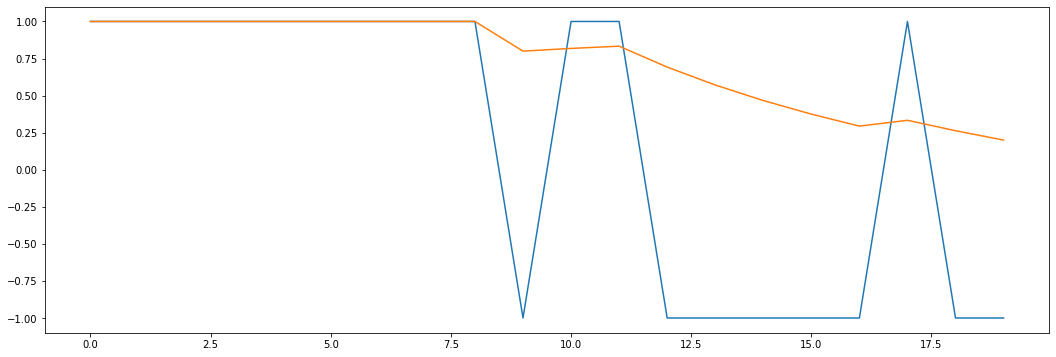

In [8]:
plot_metrics(validation_scores)

In [9]:
# drl_agent.save_model('../checkpoints/model_final.pt')

In [ ]:
controller.reset_game()

Select one of the following players to be player 1
0 - ./models/players/drl_player.py
1 - ./models/players/human_player.py
2 - ./models/players/random_player.py
